In [503]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import plotly.express as px

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import category_encoders as ce #для кодирования признаков
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [504]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [505]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Загрузка данных и проверка структуры

In [506]:
# Подгрузим наши данные из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
DATA_DIR = 'data/'
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

In [507]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [508]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [509]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [510]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [511]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [512]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


### Какой кейс решаем: 
Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.
Поставлена задача создать такую модель. 

### Признаки:
1. hotel_address - адрес отеля
2. review_date - дата, когда рецензент разместил соответствующий отзыв.
3. average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
4. hotel_name - название отеля
5. reviewer_nationality - национальность рецензента
6. negative_review - отрицательный отзыв, который рецензент дал отелю.
7. review_total_negative_word_counts - общее количество слов в отрицательном отзыв
8. positive_review - положительный отзыв, который рецензент дал отелю
9. review_total_positive_word_counts - общее количество слов в положительном отзыве
10. reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
11. total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
12. total_number_of_reviews - общее количество действительных отзывов об отеле
13. tags - теги, которые рецензент дал отелю.
14. days_since_review - продолжительность между датой проверки и датой очистки
15. additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
16. lat - широта отеля
17. lng - долгота отеля

#  Разведывательный анализ данных

In [513]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\админ\AppData\Local\Temp\ipykernel_3124\447817491.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [514]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


In [515]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [516]:
# Количество уникальных значений
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

In [517]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


array([[<AxesSubplot: title={'center': 'additional_number_of_scoring'}>,
        <AxesSubplot: title={'center': 'average_score'}>,
        <AxesSubplot: title={'center': 'review_total_negative_word_counts'}>],
       [<AxesSubplot: title={'center': 'total_number_of_reviews'}>,
        <AxesSubplot: title={'center': 'review_total_positive_word_counts'}>,
        <AxesSubplot: title={'center': 'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot: title={'center': 'lat'}>,
        <AxesSubplot: title={'center': 'lng'}>,
        <AxesSubplot: title={'center': 'sample'}>],
       [<AxesSubplot: title={'center': 'reviewer_score'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

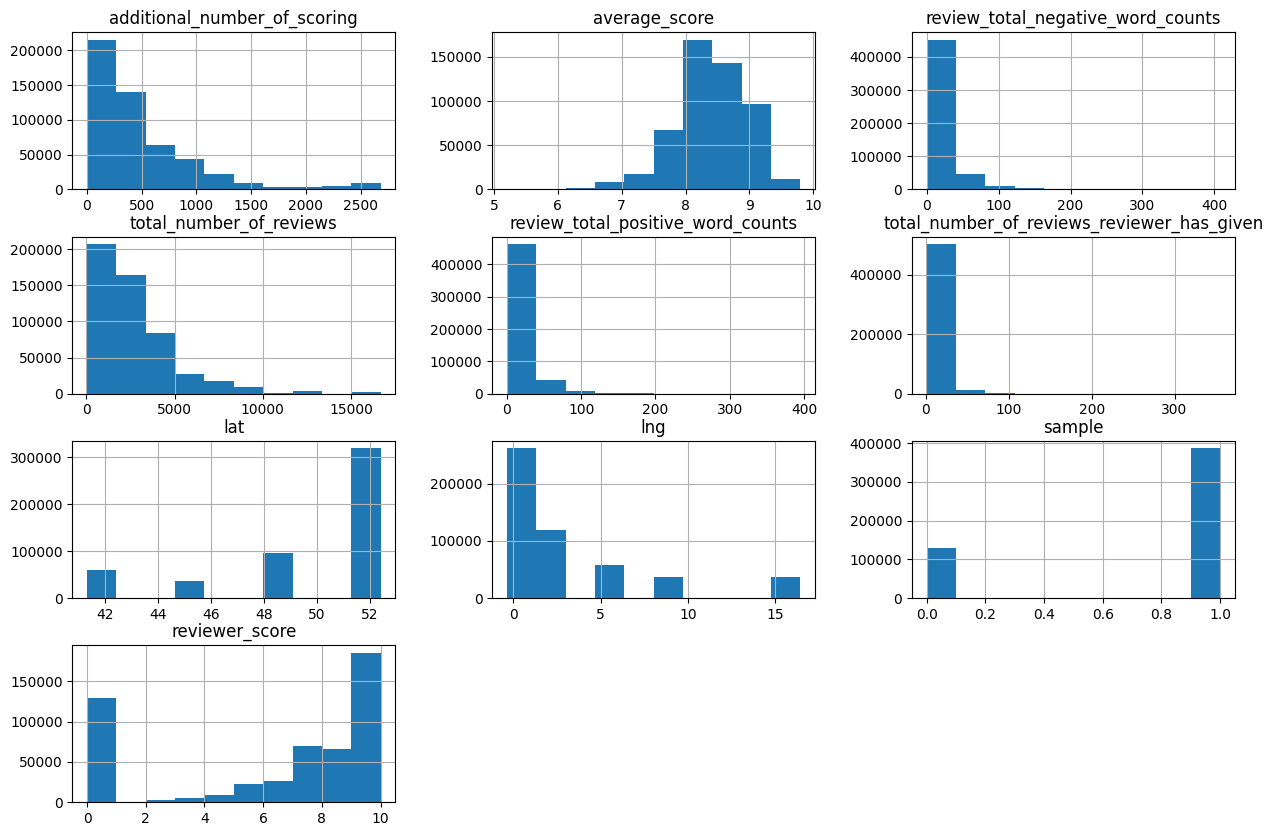

In [518]:
data.hist()

C:\Users\админ\AppData\Local\Temp\ipykernel_3124\1624597386.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot: >

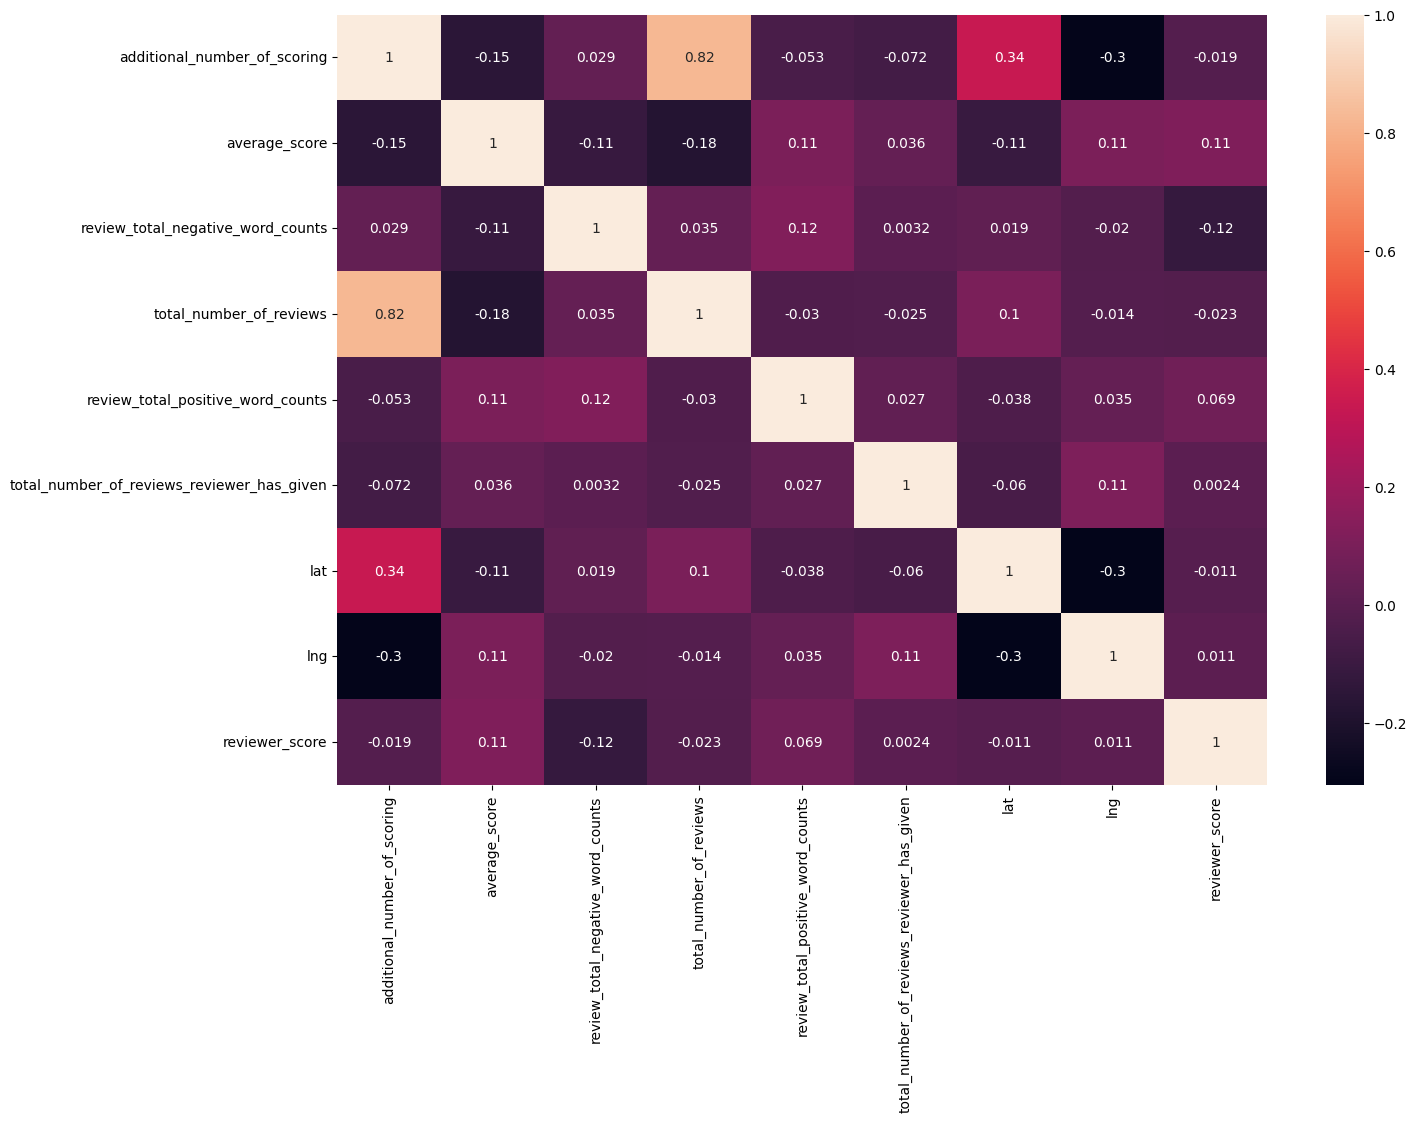

In [519]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [520]:
#Выделим числовые колонки
data_num=data.select_dtypes(include=[np.number])
num_cols=data_num.columns.values
display(num_cols)

array(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'lat', 'lng',
       'sample', 'reviewer_score'], dtype=object)

In [521]:
#Выделим  колонки с импом object
data_cat=data.select_dtypes(include=[np.object])
cat_cols=data_cat.columns.values
display(cat_cols)

C:\Users\админ\AppData\Local\Temp\ipykernel_3124\2846836837.py:2: DeprecationWarning:

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



array(['hotel_address', 'review_date', 'hotel_name',
       'reviewer_nationality', 'negative_review', 'positive_review',
       'tags', 'days_since_review'], dtype=object)

Обработка категориальных признаков

1. Признак hotel_address

In [522]:
# Выделение города и страны из адреса
def find_city_country(adr):
    # страна United Kindom состоит из двух слов, поэтому заменим их на одно: 'UK'
    adr = adr.replace('United Kingdom', 'UK') 
    # выделим в адресе только слова
    adr_list = [word for word in adr.split(' ') if word.isalpha()] 
    # вернём название города и страны
    return (adr_list[len(adr_list)-2], adr_list[len(adr_list)-1]) # вернём кортеж (город, страна)


In [523]:
# Создадим новый признак 'hotel_city' название города
data['city'] = data['hotel_address'].apply(lambda x: find_city_country(x)[0])

grouped = data.groupby('city', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))
display(grouped)
# посмотрим какое количество оценок было проставлено в зависимости от города

#строим график
fig = px.bar(
    data_frame=grouped, #датафрейм
    x='city', #ось x
    y='count', #ось y
    color='city', #расцветка в зависимости от страны
    text = 'count', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Распределение количества оценок по городам' #заголовок
)
#отображаем его
fig.show()

,city,count,mean_score
0,Amsterdam,57214,6.351014
1,Barcelona,60149,6.418190
2,London,262301,6.246694
3,Milan,37207,6.261615
4,Paris,59928,6.299141
5,Vienna,38939,6.408716


Здесь видно, что наибольшее количество оценок было проставлено отелям в Лондоне.

Text(0.5, 1.0, 'Целевая переменная reviewer_score в зависимости от города')

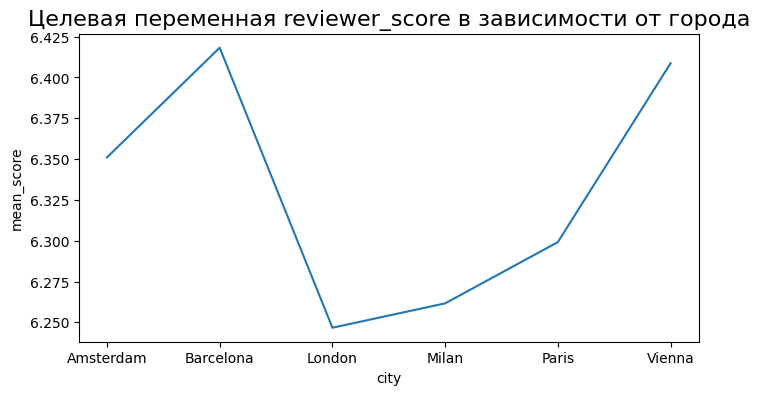

In [524]:
# Построим линейный график

fig = plt.figure(figsize=(8, 4))
fig = sns.lineplot(data=grouped, x='city', y='mean_score', markers=True)
fig.set_title('Целевая переменная reviewer_score в зависимости от города', fontdict={'fontsize':16})

Самая низкие средние оценки у отелей в Лондоне и Милане, самые высокие - в Барселоне и Вене.

In [525]:
# Создадим новый признак 'hotel_country' название города
data['country']=data['hotel_address'].apply(lambda x: find_city_country(x)[1])

grouped = data.groupby('country', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))
display(grouped)
# посмотрим какое количество оценок было проставлено в каждой стране

#строим график
fig = px.bar(
    data_frame=grouped, #датафрейм
    x='country', #ось x
    y='count', #ось y
    color='country', #расцветка в зависимости от страны
    text = 'count', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Распределение количества оценок по странам ' #заголовок
)
#отображаем его
fig.show()

,country,count,mean_score
0,Austria,38939,6.408716
1,France,59928,6.299141
2,Italy,37207,6.261615
3,Netherlands,57214,6.351014
4,Spain,60149,6.418190
5,UK,262301,6.246694


Здесь также видно, что самое большое количество оценок в Ангглии, самое маленькое количество оценок у отелей в Италии и Австрии.

Text(0.5, 1.0, 'Целевая переменная reviewer_score в зависимости от страны')

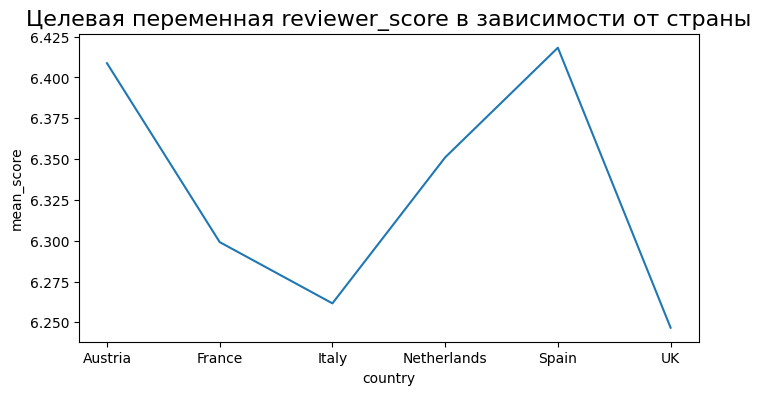

In [526]:
# Построим линейный график

fig = plt.figure(figsize=(8, 4))
fig = sns.lineplot(data=grouped, x='country', y='mean_score', markers=True)
fig.set_title('Целевая переменная reviewer_score в зависимости от страны', fontdict={'fontsize':16})

Самые низкие средние оценки у отелей в Англии и Италии, самые высокие в Австрии и Испании.

In [527]:
#кодируем признаки city и country

encoder = ce.OneHotEncoder(cols=['city'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['city'])
data = pd.concat([data, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['country'])
data = pd.concat([data, type_bin], axis=1)

data = data.drop(['hotel_address'],axis=1)

2. Признак review_date

Text(0.5, 1.0, 'Распределение отзывов по годам')

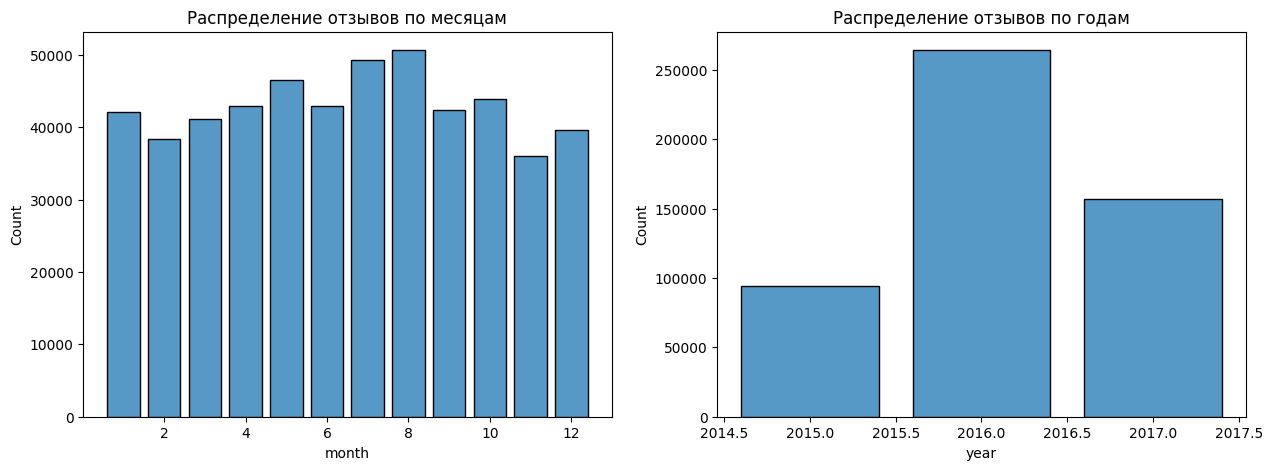

In [528]:
# Приведем признак к формату datetime
data['review_date'] = pd.to_datetime(data['review_date'])

# Выделим два новыз признака month и year
data['month'] = data['review_date'].dt.month.astype(int)
data['year'] = data['review_date'].dt.year.astype(int)


# Посмотрим на распределение количествава отзывов по месяцам и зависимость оценок от дня недели и месяца
# Графики распределения отзывов
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.histplot(data=data, x='month', discrete=True, shrink=.8, ax=ax[0])
sns.histplot(data=data, x='year', discrete=True, shrink=.8, ax=ax[1])
ax[0].set_title('Распределение отзывов по месяцам', fontdict={'size': 12})
ax[1].set_title('Распределение отзывов по годам', fontdict={'size': 12})

3. Признак hotel_name

In [529]:
data['hotel_name'].head()

0                                Hotel Da Vinci
1                             Urban Lodge Hotel
2    Alexandra Barcelona A DoubleTree by Hilton
3                      Hotel Principe Di Savoia
4                                Hotel Esther a
Name: hotel_name, dtype: object

In [530]:
data['hotel_name'].nunique()

1492

In [531]:
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования 
type_bin = bin_encoder.fit_transform(data['hotel_name']) 
data = pd.concat([data, type_bin], axis=1)
# data = data.drop(['hotel_name'],axis=1)

4. Признак reviewer_nationality

In [532]:
# Посмотрим какими национальностями предтавлены большинство путешесвенников 
data['reviewer_nationality'].value_counts(normalize=True).nlargest(15)

 United Kingdom               0.475524
 United States of America     0.068711
 Australia                    0.042048
 Ireland                      0.028749
 United Arab Emirates         0.019845
 Saudi Arabia                 0.017356
 Netherlands                  0.017009
 Switzerland                  0.016826
 Germany                      0.015397
 Canada                       0.015306
 France                       0.014147
 Israel                       0.012817
 Italy                        0.011855
 Belgium                      0.011694
 Turkey                       0.010556
Name: reviewer_nationality, dtype: float64

По  количеству отзывов наибольшее число составляют англичане,  далее идут американцы, австралийцы и ирландцы. Эти 4 национальности составляют топ-4 среди наших путешественников. У них наибольшее количество отзывов. Количество отзывов остальных путешенников не сильно отличется между собой.

In [533]:
# Выделим топ-15 национальностей, остальные назовем 'other'
top_15 = data['reviewer_nationality'].value_counts().nlargest(15).index # список стран топ-15 по кол-ву отзывов
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_15 else 'Other')

grouped = data.groupby('reviewer_nationality', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))
display(grouped)

# посмотрим какое количество оценок было проставлено в каждой стране

#строим график
fig = px.bar(
    data_frame=grouped, #датафрейм
    x='count', #ось x
    y='reviewer_nationality', #ось y
    color='reviewer_nationality', #расцветка в зависимости от страны
    text = 'count', #текст на столбцах
    orientation='h', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Зависимоть количества оценок от национальности' #заголовок
)
#отображаем его
fig.show()



,reviewer_nationality,count,mean_score
0,Australia,21686,6.432924
1,Belgium,6031,6.130857
2,Canada,7894,6.507043
3,France,7296,6.189515
4,Germany,7941,6.089107
5,Ireland,14827,6.353598
6,Israel,6610,6.473116
7,Italy,6114,6.039418
8,Netherlands,8772,6.128055
9,Saudi Arabia,8951,5.921361


In [534]:
# кодируем признак национальности с помощью LabelEncoder
data['reviewer_nationality'] = LabelEncoder().fit_transform(data['reviewer_nationality'])

5. Признак negative_review

In [535]:
data['negative_review'].value_counts().nlargest(25)

No Negative            127890
 Nothing                14295
 Nothing                 4236
 nothing                 2225
 N A                     1037
 None                     984
                          849
 N a                      509
 Breakfast                407
 Small room               373
 Location                 368
 Everything               326
 All good                 318
 Nothing really           316
 none                     302
 nothing                  283
 No complaints            274
 Price                    260
 Nothing really           254
 Nil                      247
 n a                      227
 Nothing at all           221
 Nothing to dislike       209
 Nothing at all           194
 Small rooms              188
Name: negative_review, dtype: int64

In [536]:
#приведем все к нижнему регистру
data['negative_review'] = data['negative_review'].apply(lambda x : x.lower()) 
data['negative_review'].value_counts().nlargest(25)

no negative            127890
 nothing                16627
 nothing                 4558
 n a                     1775
 none                    1297
                          849
 breakfast                502
 small room               481
 location                 447
 all good                 385
 nothing really           380
 everything               374
 no complaints            328
 nil                      310
 price                    302
 nothing really           276
 na                       264
 nothing at all           259
 small rooms              245
 nothing to dislike       239
 nothing at all           208
 none                     204
 no complaints            195
 room size                181
 no                       180
Name: negative_review, dtype: int64

In [537]:
# уберем ошибочные отзывы
mistake_negative = ['no negative','nothing','n a','none','','all good','nothing really','na','nothing at all', 'nothing to dislike', 'no']

data['negative_review_real'] = data['negative_review'].apply(lambda x : 0 if x in mistake_negative else 1)#вручную кодируем признак

data['negative_review_real'].value_counts()

1    387848
0    127890
Name: negative_review_real, dtype: int64

In [538]:
# удалим исходный признак negative_review'
data = data.drop(['negative_review'], axis=1)

6. Признак positive_review

In [539]:
data['positive_review'].value_counts().nlargest(25)

No Positive            35946
 Location               9222
 Everything             2284
 location               1677
 Nothing                1243
 The location           1126
 Great location         1047
 Good location           927
 Location                915
 Everything              613
 Breakfast               608
 Friendly staff          515
 Staff                   453
 Excellent location      392
 Great location          372
 Location and staff      333
 everything              319
 Good location           276
 Nothing                 225
 Comfy bed               222
 nothing                 217
 The location            215
 good location           206
 The staff               197
 Good breakfast          189
Name: positive_review, dtype: int64

In [540]:
#приведем все к нижнему регистру
data['positive_review'] = data['positive_review'].apply(lambda x : x.lower()) 
data['positive_review'].value_counts().nlargest(25)

no positive                    35946
 location                      10962
 everything                     2629
 nothing                        1477
 the location                   1364
 great location                 1272
 good location                  1195
 location                        983
 breakfast                       730
 everything                      685
 friendly staff                  634
 staff                           518
 excellent location              468
 great location                  415
 location and staff              412
 location staff                  371
 good location                   301
 comfy bed                       256
 nothing                         254
 good breakfast                  247
 the location                    242
 the staff                       240
 location location location      234
 all                             231
 every thing                     219
Name: positive_review, dtype: int64

In [541]:
# уберем ошибочные отзывы
mistake_positive = ['no positive','nothing']

data['positive_review_real'] = data['positive_review'].apply(lambda x : 0 if x in mistake_positive else 1)#вручную кодируем признак

data['positive_review_real'].value_counts()

1    479792
0     35946
Name: positive_review_real, dtype: int64

In [542]:
# удалим исходный признак positive_review'
data = data.drop(['positive_review'], axis=1)

7. Признак tags

In [543]:
# Проанализируем теги
tags = data['tags'].value_counts(normalize=True)
tags

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                   0.009891
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                          0.009561
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                          0.008466
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                            0.007738
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']                                                  0.006381
                                                                                                                                                            ...   
[' Leisure trip ', ' C

In [544]:
# Выделим признак 'цель путешествия' 
purpose=['Business', 'Leisure']
for tag in purpose:
    data['trip_purpose'] = data['tags'].apply(lambda x: 1 if tag in x else 0)

data['trip_purpose']

0         1
1         1
2         0
3         1
4         0
         ..
515733    1
515734    1
515735    0
515736    1
515737    1
Name: trip_purpose, Length: 515738, dtype: int64

In [545]:
# # Выделим признак 'cостав путешественников' 
who_travel= ['Solo', 'Couple', 'Family', 'Friends', 'With a pet', 'Group']
for tag in who_travel:
    data['who_travel'] = data['tags'].apply(lambda x: 1 if tag in x else 0)
data['who_travel']

0         0
1         1
2         0
3         0
4         0
         ..
515733    1
515734    0
515735    0
515736    0
515737    0
Name: who_travel, Length: 515738, dtype: int64

In [546]:
# Выделим признак 'длительность путешествия'
#Конвертируем теги в списки.
def rev_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res
data['tags'] = data['tags'].apply(rev_func)
data['tags']

def get_stay(x):
    for tag in x:
        words = tag.split()
        if words[0] =='Stayed':
            return int(words[1])
    return np.NaN

data['trip_time'] = data['tags'].apply(get_stay)
data['trip_time'].fillna(1, inplace=True)
data['trip_time']


0         2.0
1         1.0
2         1.0
3         1.0
4         2.0
         ... 
515733    2.0
515734    4.0
515735    1.0
515736    2.0
515737    4.0
Name: trip_time, Length: 515738, dtype: float64

In [547]:
# удаляем исходный признак
data = data.drop(['tags'],axis=1)

8. Признак days_since_review

In [548]:
data['days_since_review']

0         13 days
1         234 day
2         616 day
3         656 day
4         444 day
           ...   
515733    106 day
515734    171 day
515735    543 day
515736    74 days
515737    363 day
Name: days_since_review, Length: 515738, dtype: object

In [549]:
# избавимся от слова day/days и приведем признак типу int
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split(' ')[0])
data['days_since_review'] = data['days_since_review'].astype(int)
data['days_since_review']

0          13
1         234
2         616
3         656
4         444
         ... 
515733    106
515734    171
515735    543
515736     74
515737    363
Name: days_since_review, Length: 515738, dtype: int32

In [550]:
data.nunique(dropna=False)

additional_number_of_scoring                   480
review_date                                    731
average_score                                   34
hotel_name                                    1492
reviewer_nationality                            16
review_total_negative_word_counts              402
total_number_of_reviews                       1142
review_total_positive_word_counts              365
total_number_of_reviews_reviewer_has_given     198
days_since_review                              731
lat                                           1473
lng                                           1473
sample                                           2
reviewer_score                                  38
city                                             6
country                                          6
city_Milan                                       2
city_Amsterdam                                   2
city_Barcelona                                   2
city_London                    

In [551]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 46 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   hotel_name                                  515738 non-null  object        
 4   reviewer_nationality                        515738 non-null  int32         
 5   review_total_negative_word_counts           515738 non-null  int64         
 6   total_number_of_reviews                     515738 non-null  int64         
 7   review_total_positive_word_counts           515738 non-null  int64         
 8   total_number_of_reviews_reviewer_has_given  515738 non-null  int64        

9. Проверка на пропуски (признаки lat и lng)

In [552]:
data.isnull().sum()

additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
review_total_negative_word_counts                0
total_number_of_reviews                          0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
city                                             0
country                                          0
city_Milan                                       0
city_Amsterdam                                   0
city_Barcelona                                   0
city_London                    

In [553]:
data['lat'] = data['lat'].fillna(
    data.groupby(['city'])['lat'].transform(lambda x: x.mode()[0])
)
    
data['lng'] = data['lng'].fillna(
    data.groupby(['city'])['lng'].transform(lambda x: x.mode()[0])
)
    
    

#data['lat'] = data['lat'].fillna(0, inplace=True)
#data['lng'] = data['lng'].fillna(0, inplace=True)

In [554]:
#удалим оставшиеся нечисловые признаки
data = data.drop(['city'],axis=1)
data = data.drop(['country'],axis=1)
data = data.drop(['review_date'], axis=1)
data = data.drop(['hotel_name'], axis=1)

In [555]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality                        515738 non-null  int32  
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   days_since_review                           515738 non-null  int32  
 8   lat                                         515738 non-null  float64
 9   lng                                         515738 non-null  float64
 

## Нормализация

In [556]:
data.columns

Index(['additional_number_of_scoring', 'average_score', 'reviewer_nationality',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'sample', 'reviewer_score', 'city_Milan',
       'city_Amsterdam', 'city_Barcelona', 'city_London', 'city_Paris',
       'city_Vienna', 'country_Italy', 'country_Netherlands', 'country_Spain',
       'country_UK', 'country_France', 'country_Austria', 'month', 'year',
       'hotel_name_0', 'hotel_name_1', 'hotel_name_2', 'hotel_name_3',
       'hotel_name_4', 'hotel_name_5', 'hotel_name_6', 'hotel_name_7',
       'hotel_name_8', 'hotel_name_9', 'hotel_name_10', 'negative_review_real',
       'positive_review_real', 'trip_purpose', 'who_travel', 'trip_time'],
      dtype='object')

In [557]:
# непрерывные признаки
num_cols = ['trip_time', 
       'trip_purpose', 
       'who_travel', 
       'lat', 
       'lng', 
       'sample', 
       'reviewer_score',
       'review_total_negative_word_counts', 
       'total_number_of_reviews',
       'review_total_positive_word_counts', 
       'total_number_of_reviews_reviewer_has_given', 
       'days_since_review',
       'average_score',
       'additional_number_of_scoring']

# категориальные признаки 17
cat_cols = ['country_Italy',
       'country_Netherlands', 
       'country_Spain', 
       'country_UK',
       'country_France', 
       'country_Austria', 
       'city_Milan', 
       'city_Amsterdam',
       'city_Barcelona', 
       'city_London', 
       'city_Paris', 
       'city_Vienna',
       'month',
       'year',
       'reviewer_nationality',
       'negative_review_real',
       'positive_review_real',
       'hotel_name_0',
       'hotel_name_1',
       'hotel_name_2',
       'hotel_name_3',
       'hotel_name_4',
       'hotel_name_5',
       'hotel_name_6',
       'hotel_name_7',
       'hotel_name_8',
       'hotel_name_9',
       'hotel_name_10',]

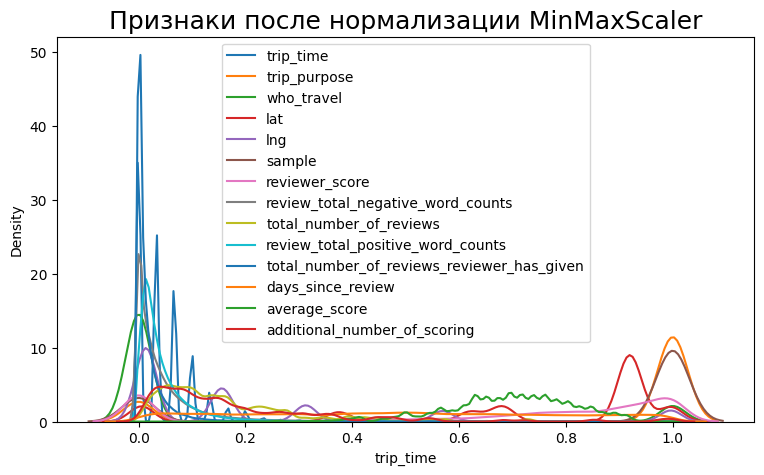

In [558]:
# Нормализация числовых признаков
from sklearn import preprocessing

mm_scaler = preprocessing.MinMaxScaler()
# скопируем эти данные
data_num = data[num_cols].copy() 

data_num_mm = mm_scaler.fit_transform(data_num)
data_num_mm = pd.DataFrame(data_num_mm, columns=num_cols)

# Визуализация
fig, (ax1) = plt.subplots(ncols=1, figsize=(9, 5))
ax1.set_title('Признаки после нормализации MinMaxScaler', fontdict={'fontsize': 18})

for col in num_cols:
    sns.kdeplot(data_num_mm[col], ax=ax1)

plt.legend(num_cols)

## Оценка мультиколлинеарности

<AxesSubplot: >

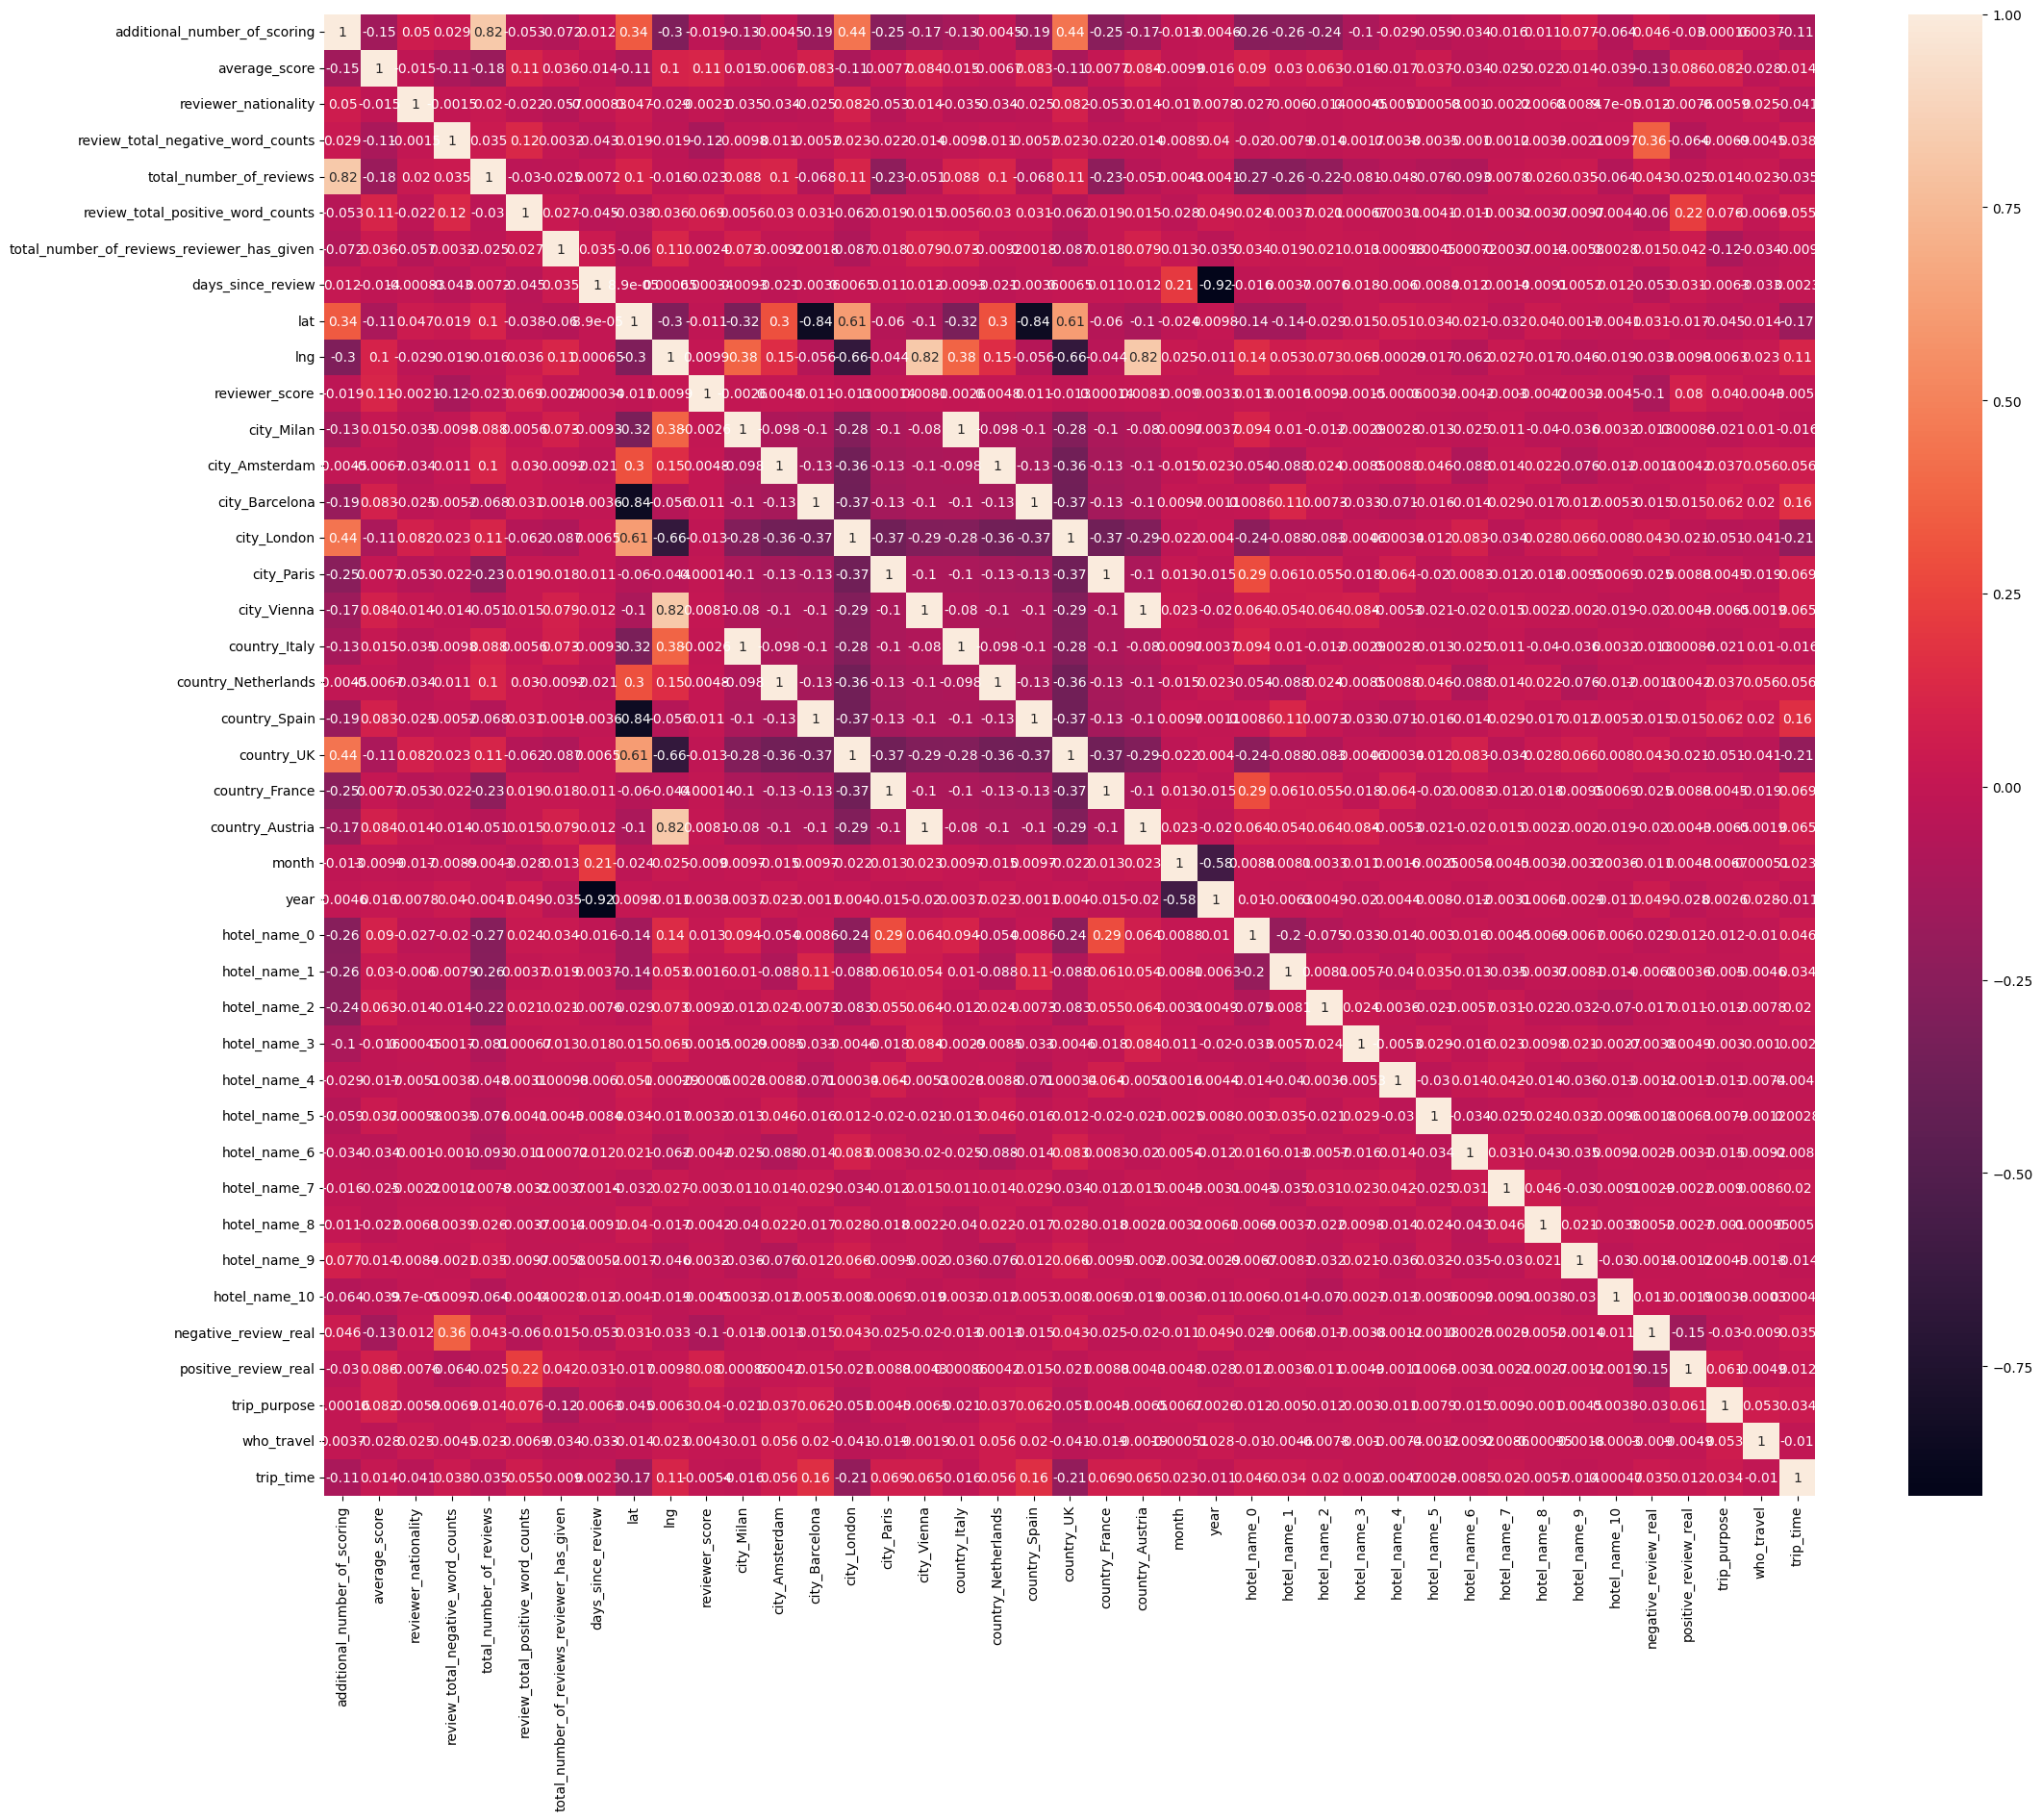

In [559]:
plt.rcParams['figure.figsize'] = (25,20)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [560]:
data.drop(['total_number_of_reviews'], axis = 1, inplace=True)
data.drop(['city_Milan'], axis = 1, inplace=True)
data.drop(['city_Amsterdam'], axis = 1, inplace=True)
data.drop(['city_Barcelona'], axis = 1, inplace=True)
data.drop(['city_London'], axis = 1, inplace=True)
data.drop(['city_Paris'], axis = 1, inplace=True)
data.drop(['city_Vienna'], axis = 1, inplace=True)
data.drop(['lng'], axis = 1, inplace=True)
data.drop(['lat'], axis = 1, inplace=True)


print(f'Текущее получившееся количество признаков: {len(data.columns)}')
print('(включая столбец "Sample" и целевой столбец)')

Текущее получившееся количество признаков: 33
(включая столбец "Sample" и целевой столбец)


# Создание и обучение модели

### Подготовка итоговых обучающих и тестовых выборок

In [561]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [562]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [563]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 32), (386803, 32), (386803, 31), (309442, 31), (77361, 31))

### Создание и обучение регрессивной модели by RandomForestRegressor

In [564]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [565]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [566]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.6s finished


### Оценка эффективности модели

1. Определение точности целевой переменной (MAPE)

In [567]:
# Функция для рассчёта MAPE:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [568]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

print('MAPE:', mape(y_test, y_pred)) # 
#print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)) 

MAE: 0.9419064360902902
MAPE: 13.580573637013044


2. Определение степени значимости признаков для обучения модели

<AxesSubplot: >

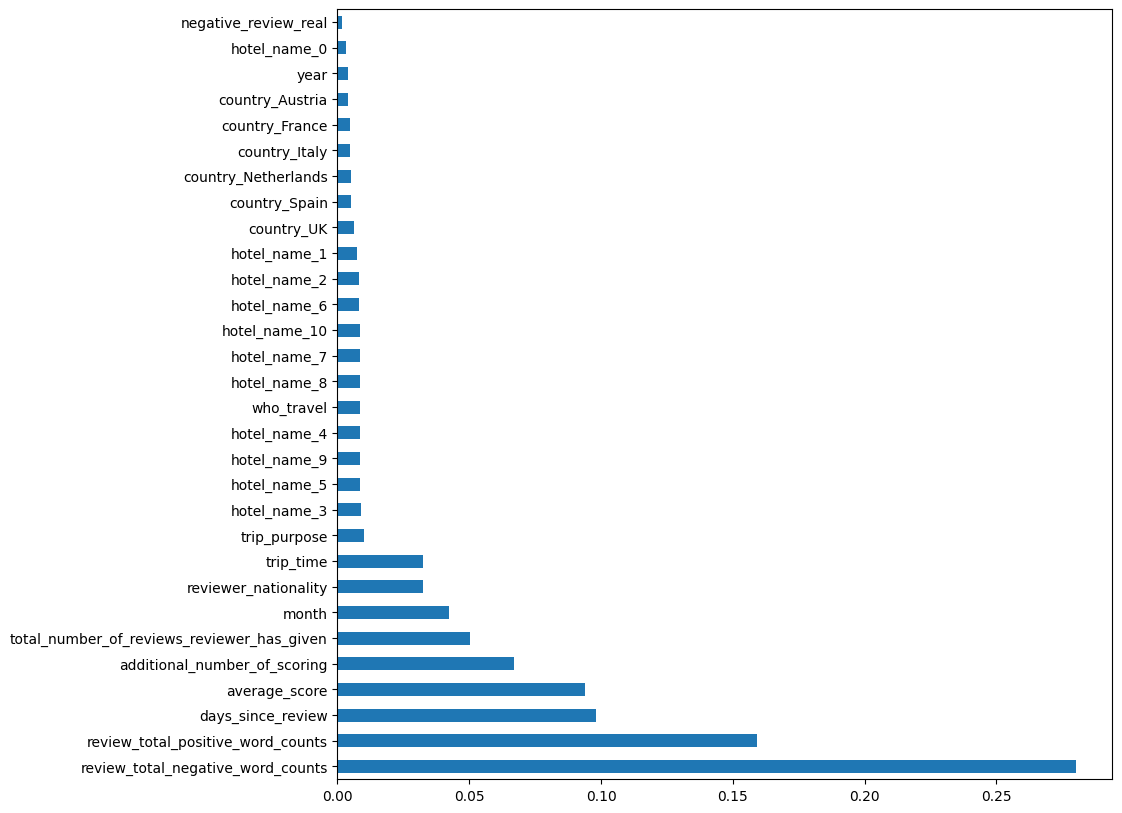

In [569]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [570]:
feat_importances.nlargest(15).index

Index(['review_total_negative_word_counts',
       'review_total_positive_word_counts', 'days_since_review',
       'average_score', 'additional_number_of_scoring',
       'total_number_of_reviews_reviewer_has_given', 'month',
       'reviewer_nationality', 'trip_time', 'trip_purpose', 'hotel_name_3',
       'hotel_name_5', 'hotel_name_9', 'hotel_name_4', 'who_travel'],
      dtype='object')

Наиболее значимыми признаками для модели стали: 'review_total_negative_word_counts','review_total_positive_word_counts', 'days_since_review',
'average_score', 'additional_number_of_scoring', 'lat', 'lng','total_number_of_reviews_reviewer_has_given', 'month','reviewer_nationality', 'trip_time', 'trip_purpose', 'who_travel','hotel_name_5', 'hotel_name_3'.

### Предсказание моделью результатов по тестовым данным

In [571]:
test_data.sample(10)

,additional_number_of_scoring,average_score,reviewer_nationality,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,country_Italy,country_Netherlands,...,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10,negative_review_real,positive_review_real,trip_purpose,who_travel,trip_time
51485,337,8.9,13,11,4,3,425,0.0,0,0,...,0,1,0,0,0,1,1,1,0,4.0
70739,122,8.9,15,14,9,21,169,0.0,0,0,...,0,1,1,0,1,1,1,1,0,1.0
45238,597,7.9,13,0,27,1,227,0.0,0,0,...,0,1,0,0,0,0,1,1,0,1.0
27175,93,9.1,13,0,43,1,399,0.0,0,0,...,1,1,1,0,0,0,1,1,0,3.0
93656,169,8.1,15,20,8,35,301,0.0,0,0,...,1,1,0,1,1,1,1,0,0,5.0
17244,297,8.3,13,45,22,5,529,0.0,0,1,...,0,1,1,1,0,1,1,1,0,3.0
85364,1243,8.1,15,0,88,7,275,0.0,0,0,...,0,1,1,1,0,0,1,1,0,7.0
100674,103,9.2,15,0,11,1,305,0.0,1,0,...,1,0,0,1,1,0,1,1,0,2.0
58115,759,7.5,13,35,14,1,80,0.0,0,0,...,0,1,0,0,0,1,1,1,0,4.0
114905,245,8.4,14,52,38,2,636,0.0,0,0,...,1,0,1,0,0,1,1,1,0,5.0


In [572]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [573]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [574]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished


In [575]:
predict_submission

array([8.593, 6.883, 8.113, ..., 7.751, 9.423, 6.495])

In [576]:
list(sample_submission)

['reviewer_score', 'id']

### Подготовка сабмишена

In [578]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission

,reviewer_score,id
0,8.593,488440
1,6.883,274649
2,8.113,374688
3,9.425,404352
4,9.565,451596
...,...,...
128930,8.700,495812
128931,7.997,315577
128932,7.751,511968
128933,9.423,303386
